In [260]:
# Base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import sys

# Configuration
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append("../")
pd.set_option('display.max_columns', None)  # 모든 열을 출력할 수 있도록 설정
pd.options.display.float_format = '{:.4f}'.format

In [261]:
# Load data
data_path = "../data/titanic/raw/train.csv"
df = pd.read_csv(data_path)

In [262]:
# PassengerId와 Name 모두 고유값이나, PassengerId는 단순한 인덱스이므로 제거
df = df.drop(columns=['PassengerId'], axis=1)

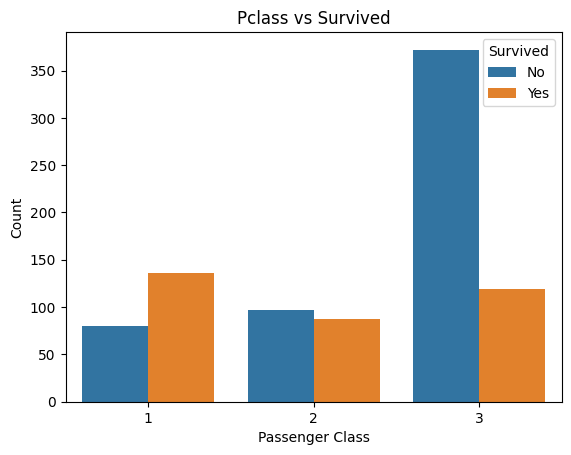

Pclass
1   0.6296
2   0.4728
3   0.2424
Name: Survived, dtype: float64

In [263]:
# 객실 등급이 높을수록 생존률이 높은 경향을 보임
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Pclass vs Survived")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived", loc='upper right', labels=['No', 'Yes'])
plt.show()

# 비율로 표현하면 더 명확하게 생존률을 확인할 수 있음
pclass_survival_rate = df.groupby('Pclass')['Survived'].mean()
pclass_survival_rate

# TODO: 범주별 나타나는 경향이 명확하게 다르기 때문에 범주형 변수로 활용할 것

In [264]:
# Name에서 얻을 수 있는 정보: 
#   shape: Lastname, Title. Firstname
#       Lastname: 성
#       Title: 호칭 (Mr, Mrs, Miss 등)
#       Firstname: 이름
# 생존률과 관련이 있을 것으로 예상되는 정보: Title, Lastname
df['Name'].head(10)
name_lastname = df['Name'].str.split(',', expand=True)[0]
name_title = df['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
name_lastname_survival_rate = df.groupby(name_lastname)['Survived'].mean()
name_title_survival_rate = df.groupby(name_title)['Survived'].mean()
name_title_survival_rate.sort_values(ascending=False)

# Lastname은 Pclass와 상관 관계가 있을 것으로 예상됨
# Lastname을 기준으로 Pclass의 고유값 개수를 확인한 결과 2개 이상의 Pclass를 가지는 경우가 약 2.5%밖에 안됨
len(df.groupby([name_lastname]).Pclass.nunique()[df.groupby([name_lastname]).Pclass.nunique()>1]) / len(name_lastname.unique()) * 100

# title은 Sex와 상관 관계가 있을 것으로 예상됨
# title을 기준으로 Sex의 고유값 개수를 확인, Dr를 제외한 모두가 하나의 성별만을 가리킴
df.groupby([name_title]).Sex.nunique()

# TODO: 가장 단순한 모델이 Survived~Sex였는데, Survived~title의 조금 더 복잡한 모델 만들고 성능 측정해보기

0
Capt            1
Col             1
Don             1
Dr              2
Jonkheer        1
Lady            1
Major           1
Master          1
Miss            1
Mlle            1
Mme             1
Mr              1
Mrs             1
Ms              1
Rev             1
Sir             1
the Countess    1
Name: Sex, dtype: int64

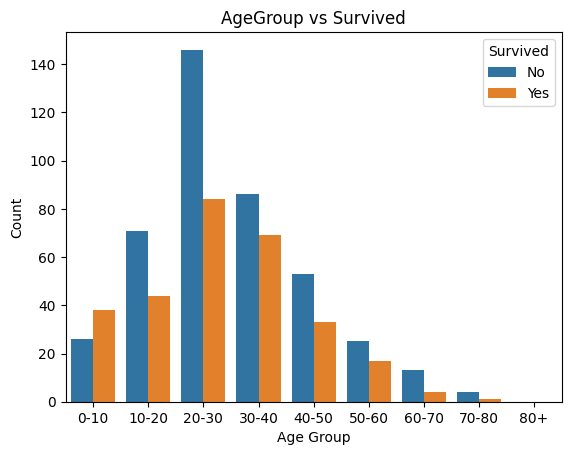

AgeGroup
0-10    0.5938
10-20   0.3826
20-30   0.3652
30-40   0.4452
40-50   0.3837
50-60   0.4048
60-70   0.2353
70-80   0.2000
80+        NaN
Name: Survived, dtype: float64

In [265]:
# 나이는 결측값이 많아 사용시 가중치 보정을 해야 할 것으로 예상됨
df.Age.describe()

# 나이가 Survived와 상관 관계가 있는지 확인하기 위해 나이를 10살 단위로 나누어 생존률을 확인
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

# Survived~Age 
sns.countplot(x='AgeGroup', hue='Survived', data=df)
plt.title("AgeGroup vs Survived")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Survived", loc='upper right', labels=['No', 'Yes'])
plt.show()

age_group_survival_rate = df.groupby('AgeGroup')['Survived'].mean()
age_group_survival_rate

# TODO: 결측치가 많은 값이다보니 사용 우선순위를 떨어뜨리고 추가했을 때 성능이 유의미하게 오른다면 결측값을 처리하는 방법에 대해 고민해보기 
# TODO: 데이터의 숫자가 적은 60+ 대를 하나로 묶어도 괜찮을 것 같음

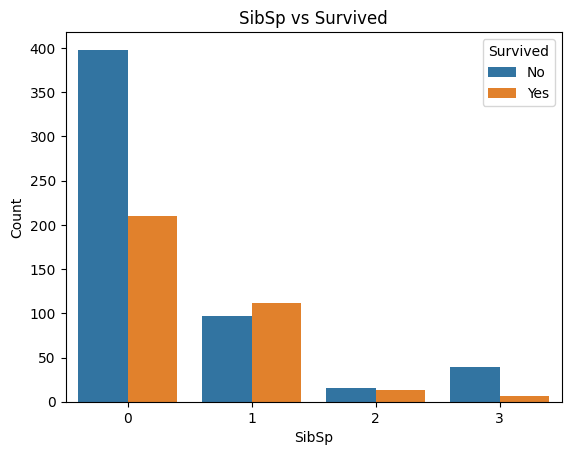

SibSp
0   0.3454
1   0.5359
2   0.4643
3   0.1522
Name: Survived, dtype: float64

In [266]:
# 형제, 배우자 수가 많을수록 생존률이 낮아질 것이라 기대
# -> 아예 없는 것보단 1~2명 있는 것이 더 생존률이 높았음

# SibSp=2 이상인 케이스가 적어 하나로 병합함
df['SibSp'] = df['SibSp'].replace([x for x in range(3, 11)], 3)

sns.countplot(x='SibSp', hue='Survived', data=df)
plt.title("SibSp vs Survived")
plt.xlabel("SibSp")
plt.ylabel("Count")
plt.legend(title="Survived", loc='upper right', labels=['No', 'Yes'])
plt.show()

sibsp_survival_rate = df.groupby('SibSp')['Survived'].mean()
sibsp_survival_rate

# SibSp=0일 때 생존자 수는 많지만 생존률은 낮음
# SibSp=1일 때 생존자 수는 적지만 생존률은 높음
# SibSp=2일 때 생존자 수도 적고 생존률도 낮음

# TODO: 생존률을 예측하고자 하므로 절대적 숫자보다는 비율을 고려한 모델을 만들 것
# TODO: 데이터 수가 적은 SibSp=3 이상인 케이스는 하나로 병합함, 2 이상을 묶는 것도 고려해볼 것
# TODO: 희소 클래스에 대한 문제를 당장은 병합으로 해결하고, 나중에 타깃 인코딩, 가중치 조정, 트리 기반 모델을 활용하는 방법으로 해결

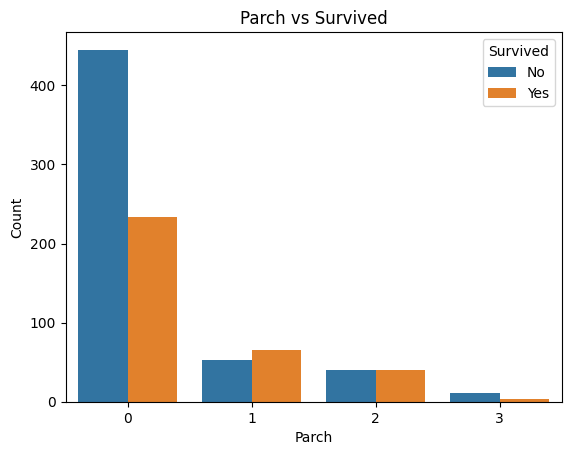

Parch
0   0.3437
1   0.5508
2   0.5000
3   0.2667
Name: Survived, dtype: float64

In [267]:
# 부모, 자녀 수가 많을수록 생존률이 낮아질 것이라 기대

df['Parch'] = df['Parch'].replace([x for x in range(3, 11)], 3)

sns.countplot(x='Parch', hue='Survived', data=df)
plt.title("Parch vs Survived")
plt.xlabel("Parch")
plt.ylabel("Count")
plt.legend(title="Survived", loc='upper right', labels=['No', 'Yes'])
plt.show()

parch_survival_rate = df.groupby('Parch')['Survived'].mean()
parch_survival_rate

# TODO: SibSp와 마찬가지로 진행, 몇 이상부터 묶을 것인지 추가 분석해보기

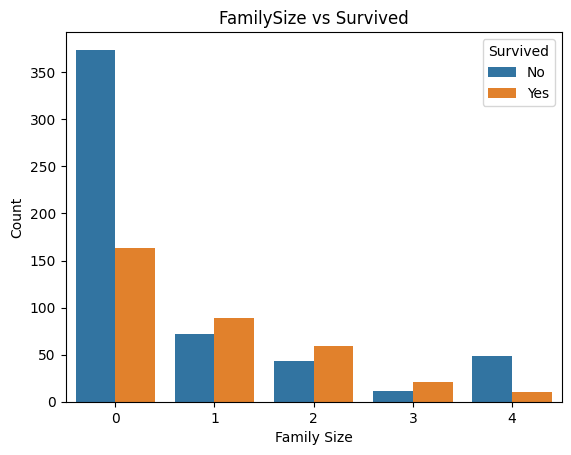

FamilySize
0   0.3035
1   0.5528
2   0.5784
3   0.6562
4   0.1695
Name: Survived, dtype: float64

In [268]:
# 형제, 배우자, 부모, 자녀 수를 합쳐서 가족 수를 만들고 생존률을 확인
df['FamilySize'] = df['SibSp'] + df['Parch']
df['FamilySize'] = df['FamilySize'].replace([x for x in range(4, 11)], 4)

sns.countplot(x='FamilySize', hue='Survived', data=df)
plt.title("FamilySize vs Survived")
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.legend(title="Survived", loc='upper right', labels=['No', 'Yes'])
plt.show()

family_size_survival_rate = df.groupby('FamilySize')['Survived'].mean()
family_size_survival_rate

# TODO: SibSp, Parch의 경향이 비슷한데 둘을 사용하는 모델과 FamilySize를 사용하는 모델의 성능을 비교해보기
# TODO: 마찬가지로 FamilySize의 병합 크기도 고민해보기

In [269]:
df['Ticket'].head(10)
# 티켓 번호는 선실 등급이나 출발 위치를 추정할 수 있는 정보로 활용 가능해보임
# 중복된 티켓 번호가 존재하고 이는 동행을 의미하고 SibSp, Parch, Lastname 등과 연관이 있을 것으로 예상
# -> 확인해보니 Lastname, SibSp, Parch과 관계가 있으며 같은 티켓이면 보통 같은 Survived를 가짐
tmp = df['Ticket'].value_counts().index
df[df['Ticket'] == tmp[2]][['SibSp', 'Parch', 'Name', 'Survived']]
# title(Mr, Miss 등)보다 Ticket이 더 큰 중요도를 갖는 것처럼 보이기도 함
df[df['Ticket'] == tmp[1]]
# 같은 Ticket, 같은 Mr 중에서 결과가 다른 원인이 뭘까? 현재 주어진 값 만으로는 구분할 수 없음

df.Ticket.value_counts().head(30)
df.Ticket[df.Ticket.str.contains(' ')].str.split(
    ' ', expand=True)[0].str.replace('.', '').nunique()

# TODO: ' '를 기준으로 티켓 고유번호(대소문자통일, '/'은일단보류, '.'제외하자, '없음')를 구하고 모델에 반영해보기

33

In [270]:
# 승선 요금은 Pclass와 상관 관계가 있을 것으로 예상됨
df['Fare'].describe()
df.groupby('Pclass')['Fare'].mean()
df.groupby('Survived')['Fare'].mean()
df.groupby('Sex')['Fare'].mean()
# 특이하게 여성의 승선 요금 평균이 남성의 두배 가까이 됨
df.groupby(['Pclass', 'FamilySize'])['Fare'].mean()
# Pclass=2, FamilySize=3일 때가 FamilySize=4일 때보다 비싼 이유를 모르겠음
df.groupby('Ticket')['Fare'].mean()
# 또한, 승선 요금을 한 사람이 내더라도 같이 결제한 사람들 모두 동일한 승선요금으로 기록한 것으로 보여 수치적 오류를 일으킬 수 있어보임

Ticket
110152        86.5000
110413        79.6500
110465        52.0000
110564        26.5500
110813        75.2500
                ...  
W./C. 6608    34.3750
W./C. 6609     7.5500
W.E.P. 5734   61.1750
W/C 14208     10.5000
WE/P 5735     71.0000
Name: Fare, Length: 681, dtype: float64

In [271]:
# 결측치가 전체의 77.1%나 차지하며 품질도 좋지 않음
df['Cabin'].sort_values().unique()
df.groupby('Cabin').size().sort_values(ascending=False).head(20)
df[df.Cabin == 'D']
df[df.Ticket == '28551']
# 일반적으로 티켓이 같으면 같은 객실, 그러나 역은 성립하지 않음, 숫자 티켓과 PC 티켓은 객실이 다를 수 있음
# 가격은 Ticket에 종속적, 객실이 같아도 가격이 다를 수 있음
df.groupby('Ticket')['Cabin'].nunique().sort_values(ascending=False).head(40)
df[df.Ticket == 'PC 17572']

# TODO: 티켓으로 Cabin을 예측할 수 있는지 확인해보고 가능하다면 모델에 반영해보기

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,FamilySize
52,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0000,1,0,PC 17572,76.7292,D33,C,40-50,1
645,1,1,"Harper, Mr. Henry Sleeper",male,48.0000,1,0,PC 17572,76.7292,D33,C,40-50,1
681,1,1,"Hassab, Mr. Hammad",male,27.0000,0,0,PC 17572,76.7292,D49,C,20-30,0


In [272]:
df[df['Embarked'].isnull()] # -> 2건, S로 채운다 (Fare와 Pclass 기준으로 가장 비슷한 승객 기준)
df.groupby('Embarked')['Survived'].mean()
# 승선 항구에 따른 생존률 차이가 결과적으로는 조금이나마 있지만 인과관계로 보기는 어렵다
df.groupby('Embarked').Pclass.mean()
# df.groupby('Embarked').Fare.mean()
# 그러나 자세히 살펴보면 Pclass, Fare와 관련된 잠재변수로 보인다

# TODO: Fare, Pclass, Embarked, Ticket, Cabin까지 모두 연관이 있는 것처럼 보이는데 어떤 방식으로 사용하는게 좋을지 고민해보기 

Embarked
C   1.8869
Q   2.9091
S   2.3509
Name: Pclass, dtype: float64

In [273]:
# TODO: 가장 좋은 모델은 Survived에 영향을 크게 미칠 것으로 예상되는 변수들로 결정 트리를 만드는 것이라 생각, 가장 직관적.
# TODO: log변환 등 해당 분석에서 스케일 조정이 필요한지 확인해보기, 필요하다면 왜 필요한지 정리하기

In [274]:
# Fare를 log 변환하여 왜도 조정
df['Fare_log'] = np.log1p(df['Fare'])

# Cabin 유무 (1등석 확률과 생존률 높음)
df['Has_Cabin'] = df['Cabin'].notnull().astype(int)

# Ticket 공유 여부
df['Ticket_GroupSize'] = df['Ticket'].map(df['Ticket'].value_counts())
df['Ticket_Shared'] = (df['Ticket_GroupSize'] > 1).astype(int)

# Embarked 더미화
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

from sklearn.decomposition import PCA

features = ['Fare_log', 'Pclass', 'Has_Cabin', 'Ticket_GroupSize']
X_pca = PCA(n_components=1).fit_transform(df[features])
df['Socioeconomic_Score'] = X_pca
df['Socioeconomic_Score']


0     -1.2397
1      0.3119
2     -1.2004
3      1.0085
4     -1.1935
        ...  
886   -0.7842
887   -0.1102
888    0.1429
889   -0.1102
890   -1.2103
Name: Socioeconomic_Score, Length: 891, dtype: float64

In [279]:
df.groupby('Survived').Socioeconomic_Score.mean()

Survived
0   -0.2121
1    0.3405
Name: Socioeconomic_Score, dtype: float64